In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./dracula.mplstyle')
import logging
LOG = logging.getLogger(__name__)
LOG.info('Hello from notebook')

from pydataset import data

import frankenfit as ff
reload(ff.core)
reload(ff.transforms)
reload(ff.graph)
reload(ff)

logging.getLogger('frankenfit').setLevel(logging.INFO)

In [2]:
df = data('diamonds')

In [3]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [4]:
sk = ff.SKLearn?

Init signature:
ff.SKLearn(
    sklearn_class: 'type | HP',
    x_cols: 'str | HP | Iterable[str | HP]',
    response_col: 'str | HP',
    hat_col: 'str | HP',
    class_params: 'dict | HP' = NOTHING,
    w_col: 'str | HP' = NOTHING,
    *,
    tag: 'str' = NOTHING,
) -> None
Docstring:     
Wrap a scikit-learn ("sklearn") model. At fit-time, the given sklearn model class
is instantiated (with arguments from ``class_params``) and trained on the fitting
data by calling its ``fit()`` method. At apply-time, the now-fit sklearn model
object is used to generated predictions by calling its `predict()` method, which are
assigned to the apply-time data as a new column, ``hat_col``.

:param sklearn_class: The sklearn class to wrap.
:param x_cols: The predictor columns. These are selected from the fit/apply-data to
    create the ``X`` argument to the sklearn model's ``fit()`` and ``predict()``
    methods.
:param response_col: The response column. At fit-time, this is selected from the
    fitt

In [5]:
import sklearn
from sklearn.linear_model import LinearRegression
sk = ff.SKLearn(LinearRegression, ['carat', 'depth', 'table'], 'price', 'price_hat', class_params={'fit_intercept': True})
sk

SKLearn(tag='SKLearn#1', sklearn_class=<class 'sklearn.linear_model._base.LinearRegression'>, x_cols=['carat', 'depth', 'table'], response_col=HPFmtStr(name='price'), hat_col=HPFmtStr(name='price_hat'), class_params={'fit_intercept': True}, w_col='')

In [6]:
fit_sk = sk.fit(df)
fit_sk

FitSKLearn(tag='SKLearn#1', sklearn_class=<class 'sklearn.linear_model._base.LinearRegression'>, x_cols=['carat', 'depth', 'table'], response_col='price', hat_col='price_hat', class_params={'fit_intercept': True}, w_col='', <53940 rows of fitting data>)

In [7]:
fit_sk._field_names

['tag',
 'sklearn_class',
 'x_cols',
 'response_col',
 'hat_col',
 'class_params',
 'w_col']

In [8]:
fit_sk.state().coef_

array([7858.77050994, -151.23634689, -104.47278016])

In [9]:
sk.params()

['tag',
 'sklearn_class',
 'x_cols',
 'response_col',
 'hat_col',
 'class_params',
 'w_col']

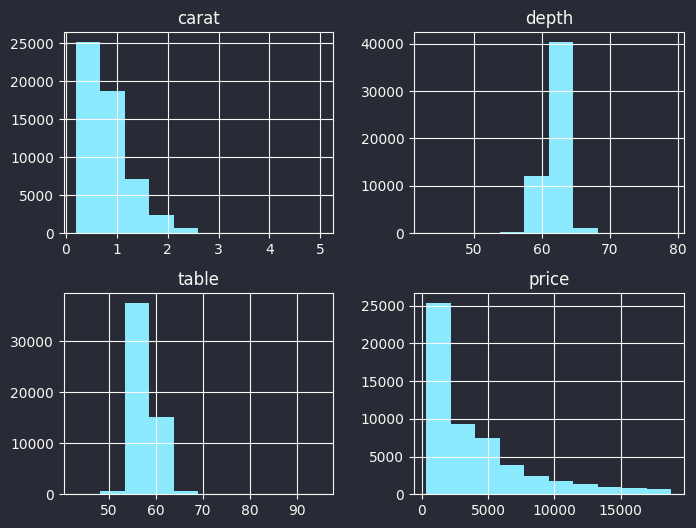

In [10]:
df[['carat', 'depth', 'table', 'price']].hist(figsize=(8,6));

In [13]:
from sklearn.linear_model import LinearRegression

FEATURES = ["carat", "x", "y", "z", "depth", "table"]

def bake_features(cols):
    return (
        ff.Pipeline()
        .print(fit_msg=f"Baking: {cols}")
        .winsorize(cols, limit=0.05)
        .z_score(cols)
        .impute_constant(cols, 0.)
        .clip(cols, upper=2, lower=-2)
    )

pipeline = (
    ff.Pipeline()
    .copy("{response_col}", "{response_col}_train")
    .winsorize("{response_col}_train", limit=0.05)
    .pipe(["carat", "{response_col}_train"], np.log1p)
    .if_hyperparam_is_true("bake_features", bake_features(FEATURES))
    .sklearn(
        LinearRegression,
        #x_cols=["carat", "depth", "table"],
        x_cols=ff.HP('predictors'),
        response_col="{response_col}_train",
        hat_col="{response_col}_hat",
        class_params={"fit_intercept": True}
    )
    # transform {response_col}_hat from log-dollars back to dollars
    .copy("{response_col}_hat", "{response_col}_hat_dollars")
    .pipe("{response_col}_hat_dollars", np.expm1)
)
pipeline

Pipeline(tag='Pipeline#27', transforms=[Copy(cols=['{response_col}'], tag='Copy#2', dest_cols=['{response_col}_train']), Winsorize(tag='Winsorize#3', cols=['{response_col}_train'], limit=0.05), Pipe(cols=['carat', '{response_col}_train'], tag='Pipe#2', apply_fun=<ufunc 'log1p'>), IfHyperparamIsTrue(tag='IfHyperparamIsTrue#2', name='bake_features', then=Pipeline(tag='Pipeline#23', transforms=[Print(tag='Print#2', fit_msg="Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']", apply_msg=None, dest=None), Winsorize(tag='Winsorize#4', cols=['carat', 'x', 'y', 'z', 'depth', 'table'], limit=0.05), ZScore(tag='ZScore#2', cols=['carat', 'x', 'y', 'z', 'depth', 'table'], w_col=None), ImputeConstant(cols=['carat', 'x', 'y', 'z', 'depth', 'table'], tag='ImputeConstant#2', value=0.0), Clip(cols=['carat', 'x', 'y', 'z', 'depth', 'table'], tag='Clip#2', upper=2, lower=-2)]), otherwise=None, allow_unresolved=False), SKLearn(tag='SKLearn#3', sklearn_class=<class 'sklearn.linear_model._base.LinearRegress

In [14]:
pipeline.hyperparams()

{'bake_features', 'predictors', 'response_col'}

In [15]:
sd = ff.core.SentinelDict({'response_col': 'x'})
'{response_col}_train'.format(**sd)

'x_train'

In [16]:
sd.keys_checked

In [17]:
pipeline.transforms[0].hyperparams()

{'response_col'}

In [22]:
df = data('diamonds')
index_all = set(df.index)
index_in = set(np.random.choice(df.index, size=int(len(df) / 2), replace=False))
index_out = index_all - index_in
df_in = df.loc[list(index_in)]
df_out = df.loc[list(index_out)]
    
import itertools

fits = []
for bf in (True, False):
    bindings = {'bake_features': bf, 'response_col': 'price', 'predictors': FEATURES}
    print(bindings)
    fit_pipeline = pipeline.fit(df_in, bindings)
    fits.append(fit_pipeline)


{'bake_features': True, 'response_col': 'price', 'predictors': ['carat', 'x', 'y', 'z', 'depth', 'table']}
Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']
{'bake_features': False, 'response_col': 'price', 'predictors': ['carat', 'x', 'y', 'z', 'depth', 'table']}


In [23]:
for fit in fits:
    # performance on own training data
    pdf = fit.apply(df_in)
    corr_train = pdf[['price_hat', 'price_train']].corr().iloc[0,1]
    corr_raw = pdf[['price_hat_dollars', 'price']].corr().iloc[0,1]
    print(fit.bindings())
    print('\tCorr with in-sample training response:\t%.4f' % corr_train)
    print('\tCorr with in-sample raw response:\t%.4f' % corr_raw)

{'bake_features': True, 'response_col': 'price', 'predictors': ['carat', 'x', 'y', 'z', 'depth', 'table']}
	Corr with in-sample training response:	0.9683
	Corr with in-sample raw response:	0.9310
{'bake_features': False, 'response_col': 'price', 'predictors': ['carat', 'x', 'y', 'z', 'depth', 'table']}
	Corr with in-sample training response:	0.9576
	Corr with in-sample raw response:	0.8459


In [24]:
for fit in fits:
    # performance on held-out data
    pdf = fit.apply(df_out)
    corr_train = pdf[['price_hat', 'price_train']].corr().iloc[0,1]
    corr_raw = pdf[['price_hat_dollars', 'price']].corr().iloc[0,1]
    print(fit.bindings())
    print('\tCorr with out-of-sample training response:\t%.4f' % corr_train)
    print('\tCorr with out-of-sample raw response:\t\t%.4f' % corr_raw)

{'bake_features': True, 'response_col': 'price', 'predictors': ['carat', 'x', 'y', 'z', 'depth', 'table']}
	Corr with out-of-sample training response:	0.9681
	Corr with out-of-sample raw response:		0.9311
{'bake_features': False, 'response_col': 'price', 'predictors': ['carat', 'x', 'y', 'z', 'depth', 'table']}
	Corr with out-of-sample training response:	0.9556
	Corr with out-of-sample raw response:		0.0102


In [42]:
import yfinance

In [44]:
x = yfinance.Ticker('MSFT')

In [49]:
df = x.history()

In [50]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-05-31,272.529999,274.769989,268.929993,271.869995,37827700,0,0
2022-06-01,275.200012,277.690002,270.040009,272.420013,25292200,0,0
2022-06-02,264.450012,274.649994,261.600006,274.579987,44008200,0,0
2022-06-03,270.309998,273.450012,268.410004,270.019989,28048000,0,0
2022-06-06,272.059998,274.179993,267.220001,268.750000,22400300,0,0


In [61]:
x.financials

,2021-06-30,2020-06-30,2019-06-30,2018-06-30
Research Development,20716000000.0,19269000000.0,16876000000.0,14726000000.0
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,71102000000.0,53036000000.0,43688000000.0,36474000000.0
Minority Interest,None,None,None,None
Net Income,61271000000.0,44281000000.0,39240000000.0,16571000000.0
Selling General Administrative,25224000000.0,24523000000.0,23098000000.0,22223000000.0
Gross Profit,115856000000.0,96937000000.0,82933000000.0,72007000000.0
Ebit,69916000000.0,53145000000.0,42959000000.0,35058000000.0
Operating Income,69916000000.0,53145000000.0,42959000000.0,35058000000.0
Other Operating Expenses,None,None,None,None


In [74]:
yfinance.download?

Signature:
yfinance.download(
    tickers,
    start=None,
    end=None,
    actions=False,
    threads=True,
    group_by='column',
    auto_adjust=False,
    back_adjust=False,
    progress=True,
    period='max',
    show_errors=True,
    interval='1d',
    prepost=False,
    proxy=None,
    rounding=False,
    timeout=None,
    **kwargs,
)
Docstring:
Download yahoo tickers
:Parameters:
    tickers : str, list
        List of tickers to download
    period : str
        Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        Either Use period parameter or use start and end
    interval : str
        Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        Intraday data cannot extend last 60 days
    start: str
        Download start date string (YYYY-MM-DD) or _datetime.
        Default is 1900-01-01
    end: str
        Download end date string (YYYY-MM-DD) or _datetime.
        Default is now
    group_by : str
        Group by 'ticker' or 'column' (default)
  

In [75]:
x = yfinance.download(['msft', 'aapl'], start='2010-01-01', auto_adjust=True)

[*********************100%***********************]  2 of 2 completed


In [77]:
x.head()

Close                 High                  Low             \
                AAPL       MSFT      AAPL       MSFT      AAPL       MSFT   
Date                                                                        
2010-01-04  6.535086  23.800222  6.550049  23.915571  6.485312  23.523386   
2010-01-05  6.546383  23.807917  6.583332  23.915576  6.511877  23.561840   
2010-01-06  6.442255  23.661808  6.572341  23.900194  6.435537  23.469561   
2010-01-07  6.430346  23.415728  6.473708  23.607975  6.383625  23.215790   
2010-01-08  6.473097  23.577223  6.473708  23.746400  6.383931  23.254247   

                Open                Volume            
                AAPL       MSFT       AAPL      MSFT  
Date                                                  
2010-01-04  6.517375  23.546456  493729600  38409100  
2010-01-05  6.553102  23.723329  601904800  49749600  
2010-01-06  6.546384  23.746396  552160000  58182400  
2010-01-07  6.466073  23.554144  477131200  50559700  
2010-01-08  6.421796  23.285007  447610800  51197400

In [78]:
x.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index(level=1)

,Ticker,Close,High,Low,Open,Volume
Date,,,,,,
2010-01-04,AAPL,6.535086,6.550049,6.485312,6.517375,493729600
2010-01-04,MSFT,23.800222,23.915571,23.523386,23.546456,38409100
2010-01-05,AAPL,6.546383,6.583332,6.511877,6.553102,601904800
2010-01-05,MSFT,23.807917,23.915576,23.561840,23.723329,49749600
2010-01-06,AAPL,6.442255,6.572341,6.435537,6.546384,552160000
...,...,...,...,...,...,...
2022-06-28,MSFT,256.480011,266.910004,256.320007,263.980011,27295500
2022-06-29,AAPL,139.229996,140.669998,136.669998,137.460007,66177800
2022-06-29,MSFT,260.260010,261.970001,255.759995,257.589996,20042400


<AxesSubplot:xlabel='Date'>

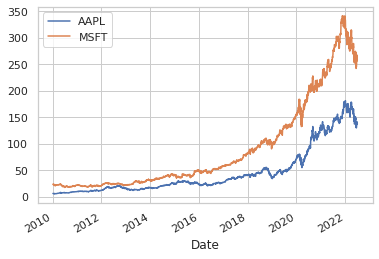

In [79]:
x['Close'].plot()

In [80]:
x.describe()

Close                      High                       Low  \
              AAPL         MSFT         AAPL         MSFT         AAPL   
count  3145.000000  3145.000000  3145.000000  3145.000000  3145.000000   
mean     45.558384    89.467204    46.035423    90.314184    45.045779   
std      44.319403    85.601362    44.851387    86.492648    43.749395   
min       5.864507    17.857401     5.985125    18.097989     5.809542   
25%      16.448139    25.566660    16.592351    25.692514    16.307943   
50%      26.655197    48.373638    26.917357    48.634932    26.448585   
75%      50.637508   122.509201    51.033438   123.761090    50.225568   
max     181.511703   341.606354   182.439174   348.137633   178.629624   

                           Open                     Volume                
              MSFT         AAPL         MSFT          AAPL          MSFT  
count  3145.000000  3145.000000  3145.000000  3.145000e+03  3.145000e+03  
mean     88.530614    45.537830    89.447583  2.633266e+08  3.843883e+07  
std      84.626493    44.295218    85.601217  2.241274e+08  2.169913e+07  
min      17.640107     5.874278    17.919493  4.100000e+07  7.425600e+06  
25%      25.308378    16.458712    25.511162  1.061120e+08  2.406050e+07  
50%      47.843931    26.688814    48.102243  1.762672e+08  3.277580e+07  
75%     121.931710    50.672313   122.780929  3.584476e+08  4.769180e+07  
max     340.700368   182.130025   343.109746  1.880998e+09  3.193179e+08